<a href="https://colab.research.google.com/github/vikas1888/Visual-Search-Retrieval-Detection-in-Multi-Spectral-Satellite-Imagery/blob/main/excCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

!git clone https://github.com/neoalwayz/TASK_PS03.git
%cd TASK_PS03
!ls data
!ls data/images
!ls data/chips

Cloning into 'TASK_PS03'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 39 (delta 0), reused 0 (delta 0), pack-reused 38 (from 2)
Receiving objects: 100% (39/39), 132.59 MiB | 18.18 MiB/s, done.
Resolving deltas: 100% (6/6), done.
Updating files: 100% (27/27), done.
/content/TASK_PS03
'Brick Kiln'   Sheds  'Solar Panel'
ls: cannot access 'data/images': No such file or directory
ls: cannot access 'data/chips': No such file or directory


In [2]:
import os
for root, dirs, files in os.walk("data"):
    print(root, ":", len(files), "files")
    for f in files[:5]:
        print("  ", f)
    print("----")


data : 0 files
----
data/Sheds : 9 files
   GC01PS03T0240.json
   GC01PS03D0123.tif
   Thumbs.db
   GC01PS03T0240.tif.aux.xml
   GC01PS03D0123.tif.aux.xml
----
data/Brick Kiln : 7 files
   GC01PS03D0028.json
   GC01PS03D0011.tif
   GC01PS03D0028.tif
   Thumbs.db
   GC01PS03D0028.jpg
----
data/Solar Panel : 9 files
   GC01PS03D0155.json
   GC01PS03T0240.json
   GC01PS03D0155.jpg
   Thumbs.db
   annotated.jpg
----


In [3]:
SAT_IMAGE_DIR = "data/images"
CHIP_DIR = "data/chips"



In [4]:
import glob
sat_files = glob.glob(os.path.join(SAT_IMAGE_DIR, "*.tif"))  # or *.png etc.
chip_files = glob.glob(os.path.join(CHIP_DIR, "*.tif"))



In [5]:
def load_multiband(path):
    ext = path.lower().split('.')[-1]
    if ext in ["tif", "tiff"]:
        arr = tiff.imread(path)
    elif ext in ["png", "jpg", "jpeg"]:
        import imageio
        arr2 = imageio.imread(path)

        arr = arr2
    else:
        raise ValueError("Unsupported extension: " + ext)

    if arr.ndim == 3 and arr.shape[0] in [3,4]:

        return arr.astype(np.float32)
    if arr.ndim == 3 and arr.shape[2] in [3,4]:
        return np.transpose(arr, (2,0,1)).astype(np.float32)
    raise ValueError(f"Unexpected shape {arr.shape}")


In [6]:

!pip install tifffile scikit-image scikit-learn ipywidgets --quiet

import os, sys, math, json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.widgets import RectangleSelector
from skimage.draw import disk, rectangle
import tifffile as tiff
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.3 MB/s eta 0:00:00


In [10]:


import os, sys, math, json, tempfile
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.widgets import RectangleSelector
from skimage.draw import disk, rectangle
from sklearn.metrics.pairwise import cosine_similarity


try:
    import tifffile as tiff
    HAVE_TIFF = True
except Exception:
    HAVE_TIFF = False
    print("tifffile not available; notebook will still run but will save chips as .npy. Install tifffile for real TIFFs.")


In [11]:
import os


OUT_DIR = "/content/visual_search_demo"
os.makedirs(OUT_DIR, exist_ok=True)


SAT_IMAGE_DIR = "data/images"   # <-- adjust if folder name differs
CHIP_DIR = "data/chips"         # <-- adjust if folder name differs

RESULTS_TXT = os.path.join(OUT_DIR, "detections.txt")

print("Satellite image dir:", SAT_IMAGE_DIR)
print("Chip dir:", CHIP_DIR)
print("Output dir:", OUT_DIR)



Satellite image dir: data/images
Chip dir: data/chips
Output dir: /content/visual_search_demo


In [13]:
import os

for root, dirs, files in os.walk("data"):
    print(root, ":", len(files), "files")
    for f in files[:5]:
        print("   ", f)
    print("----")


data : 0 files
----
data/Sheds : 9 files
    GC01PS03T0240.json
    GC01PS03D0123.tif
    Thumbs.db
    GC01PS03T0240.tif.aux.xml
    GC01PS03D0123.tif.aux.xml
----
data/Brick Kiln : 7 files
    GC01PS03D0028.json
    GC01PS03D0011.tif
    GC01PS03D0028.tif
    Thumbs.db
    GC01PS03D0028.jpg
----
data/Solar Panel : 9 files
    GC01PS03D0155.json
    GC01PS03T0240.json
    GC01PS03D0155.jpg
    Thumbs.db
    annotated.jpg
----


In [14]:
from glob import glob

sat_files = glob("data/*/*.tif")   # looks inside Sheds/, Brick Kiln/, Solar Panel/
print("Found satellite images:", len(sat_files))
print("Example:", sat_files[:3])


Found satellite images: 6
Example: ['data/Sheds/GC01PS03D0123.tif', 'data/Sheds/GC01PS03T0240.tif', 'data/Brick Kiln/GC01PS03D0011.tif']


In [15]:
chip_files = glob("data/*/*.jpg")
print("Found chip images:", len(chip_files))
print("Example:", chip_files[:3])


Found chip images: 8
Example: ['data/Sheds/GC01PS03T0240.jpg', 'data/Sheds/GC01PS03D0123.jpg', 'data/Brick Kiln/GC01PS03D0028.jpg']


In [16]:
SAT_IMAGE_DIR = "data/*/*.tif"
CHIP_DIR = "data/*/*.jpg"


In [17]:
sat_files = glob(SAT_IMAGE_DIR)
chip_files = glob(CHIP_DIR)


In [18]:
import os

detections = []
for chip_path in chip_files:
    obj_name = os.path.basename(os.path.dirname(chip_path))  # folder name = class



In [19]:
from glob import glob

chip_files = glob("data/*/*.jpg")   # chips
sat_files = glob("data/*/*.tif")   # satellite images

print("Number of chip files:", len(chip_files))
print("Number of satellite images:", len(sat_files))


Number of chip files: 8
Number of satellite images: 6


In [20]:
print("Example chip:", chip_files[0])
print("Example satellite:", sat_files[0])


Example chip: data/Sheds/GC01PS03T0240.jpg
Example satellite: data/Sheds/GC01PS03D0123.tif


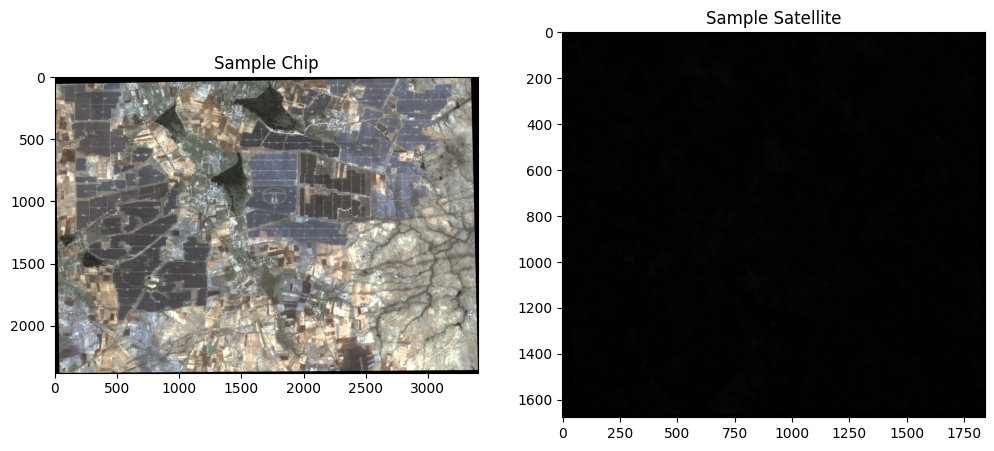

In [21]:
import cv2
import matplotlib.pyplot as plt
import random

chip = cv2.imread(random.choice(chip_files))
sat = cv2.imread(random.choice(sat_files))

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(chip, cv2.COLOR_BGR2RGB))
plt.title("Sample Chip")

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(sat, cv2.COLOR_BGR2RGB))
plt.title("Sample Satellite")
plt.show()


In [22]:
import cv2

def load_and_preprocess(path, size=(64,64)):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    img = cv2.resize(img, size)
    return img


In [23]:
import numpy as np

def feature_vector(img):

    hist = []
    for i in range(img.shape[2] if len(img.shape)==3 else 1):
        h = cv2.calcHist([img],[i],None,[32],[0,256])
        hist.extend(h.flatten())
    hist = np.array(hist)
    return hist / np.linalg.norm(hist)


In [24]:
from sklearn.metrics.pairwise import cosine_similarity

def search_chip_in_satellite(chip, sat_img):
    chip_feat = feature_vector(chip)
    sat_feat = feature_vector(sat_img)
    sim = cosine_similarity([chip_feat],[sat_feat])[0][0]
    return sim


In [25]:


import os, sys, math, json, tempfile
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.widgets import RectangleSelector
from skimage.draw import disk, rectangle
from sklearn.metrics.pairwise import cosine_similarity

# Try import tifffile (preferred for reading/writing .tif)
try:
    import tifffile as tiff
    HAVE_TIFF = True
except Exception:
    HAVE_TIFF = False
    print("tifffile not available; notebook will still run but will save chips as .npy. Install tifffile for real TIFFs.")


In [27]:
OUT_DIR = "/content/visual_search_demo"    # change if you want a different path
os.makedirs(OUT_DIR, exist_ok=True)
MOCK_DIR = os.path.join(OUT_DIR, "mock_tiffs")
os.makedirs(MOCK_DIR, exist_ok=True)
SAMPLE_DIR = os.path.join(OUT_DIR, "sample_chips")
os.makedirs(SAMPLE_DIR, exist_ok=True)
RESULTS_TXT = os.path.join(OUT_DIR, "detections.txt")

print("Output directory:", OUT_DIR)


Output directory: /content/visual_search_demo


In [29]:
from skimage.draw import disk, rectangle

def make_mock_image(size=(256,256), num_objects=3, seed=None):
    if seed is not None:
        np.random.seed(seed)
    h, w = size
    img = np.zeros((4,h,w), dtype=np.float32)  # 4 bands
    img += np.random.rand(4,1,1)*0.05

    for i in range(num_objects):
        if np.random.rand() < 0.6:
            r = np.random.randint(8,30)
            cy = np.random.randint(r, h-r)
            cx = np.random.randint(r, w-r)
            rr, cc = disk((cy, cx), r, shape=(h,w))
        else:
            hh = np.random.randint(16,64)
            ww = np.random.randint(16,64)
            cy = np.random.randint(0, h-hh)
            cx = np.random.randint(0, w-ww)
            rr, cc = rectangle(start=(cy,cx), extent=(hh,ww), shape=(h,w))

        # Build mask
        mask = np.zeros((h,w), dtype=bool)
        mask[rr, cc] = True

        band_profile = np.clip(np.random.rand(4)*0.8 + 0.2, 0,1)
        for b in range(4):
            noise = 0.05*np.random.rand(mask.sum())
            img[b][mask] = band_profile[b] + noise

    img += 0.02*np.random.randn(*img.shape)
    img = np.clip(img, 0, 1)
    return img


In [30]:
import tifffile as tiff

for i in range(6):
    arr = make_mock_image(seed=100+i)
    fname = os.path.join(MOCK_DIR, f"mock_{i:02d}.tif")
    tiff.imwrite(fname, arr.astype(np.float32))

print("Mock images created at:", MOCK_DIR)
print("Files:", sorted(os.listdir(MOCK_DIR)))


Mock images created at: /content/visual_search_demo/mock_tiffs
Files: ['mock_00.tif', 'mock_01.tif', 'mock_02.tif', 'mock_03.tif', 'mock_04.tif', 'mock_05.tif']


(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

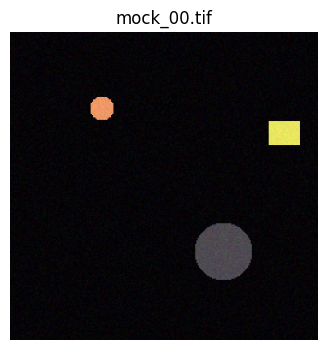

In [31]:
def load_multiband(path):
    if path.endswith(".npy"):
        arr = np.load(path)
    else:
        if not HAVE_TIFF:
            raise RuntimeError("tifffile not installed; cannot read .tif")
        arr = tiff.imread(path)
    # accept (bands, H, W) or (H, W, bands)
    if arr.ndim == 3 and arr.shape[0] == 4:
        return arr.astype(np.float32)
    if arr.ndim == 3 and arr.shape[2] == 4:
        return np.transpose(arr, (2,0,1)).astype(np.float32)
    raise ValueError(f"Unexpected array shape: {arr.shape}")

def rgb_preview(img, bands=(2,1,0)):
    # Create an RGB preview from multi-spectral (default R,G,B)
    out = np.stack([img[b] for b in bands], axis=-1)
    out = (out - out.min()) / (out.max() - out.min() + 1e-9)
    return out

# preview first mock image
first = sorted(os.listdir(MOCK_DIR))[0]
arr = load_multiband(os.path.join(MOCK_DIR, first))
plt.figure(figsize=(4,4)); plt.imshow(rgb_preview(arr)); plt.title(first); plt.axis('off')


Saved sample chip at: /content/visual_search_demo/sample_chips/chip_01.tif


(np.float64(-0.5), np.float64(69.5), np.float64(69.5), np.float64(-0.5))

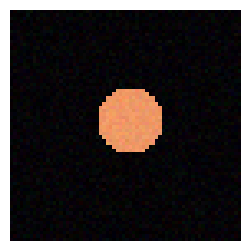

In [32]:

def save_chip_from_image(image_path, bbox, out_name):
    arr = load_multiband(image_path)
    xmin,ymin,xmax,ymax = bbox
    chip = arr[:, ymin:ymax, xmin:xmax]
    outpath = os.path.join(SAMPLE_DIR, out_name)
    if HAVE_TIFF:
        tiff.imwrite(outpath, chip.astype(np.float32))
    else:
        np.save(outpath, chip.astype(np.float32))
    return outpath


def select_bbox_interactive(image_path, default_bbox=None):
    arr = load_multiband(image_path)
    fig, ax = plt.subplots(1, figsize=(6,6))
    ax.imshow(rgb_preview(arr)); ax.axis('off'); ax.set_title("Draw rectangle to select chip, then close the figure")
    bbox_holder = {}
    def onselect(eclick, erelease):
        x1,y1 = int(eclick.xdata), int(eclick.ydata)
        x2,y2 = int(erelease.xdata), int(erelease.ydata)
        xmin, xmax = sorted([x1,x2])
        ymin, ymax = sorted([y1,y2])
        bbox_holder['bbox'] = (xmin, ymin, xmax, ymax)
        ax.add_patch(Rectangle((xmin,ymin), xmax-xmin, ymax-ymin, fill=False, color='red', linewidth=2))
        fig.canvas.draw()
    try:
        rect_selector = RectangleSelector(ax, onselect, drawtype='box')
        plt.show()
    except Exception as e:
        # headless environment: return default bbox
        print("Interactive selector not available. Using default bbox.")
    return bbox_holder.get('bbox', default_bbox)


default_bbox = (40, 30, 110, 100)
first_path = os.path.join(MOCK_DIR, sorted(os.listdir(MOCK_DIR))[0])
chip_path = save_chip_from_image(first_path, default_bbox, "chip_01.tif" if HAVE_TIFF else "chip_01.npy")
print("Saved sample chip at:", chip_path)
plt.figure(figsize=(3,3)); plt.imshow(rgb_preview(load_multiband(chip_path))); plt.axis('off')


In [33]:
def extract_feature_hist_stats(img, nbins=16):
    # img: (4,H,W)
    feats = []
    for b in range(img.shape[0]):
        band = img[b].ravel()
        hist,_ = np.histogram(band, bins=nbins, range=(0,1), density=True)
        feats.append(hist)
        feats.append([band.mean(), band.std()])
    feat = np.hstack(feats)
    feat = feat / (np.linalg.norm(feat) + 1e-9)
    return feat


In [34]:
def sliding_window_search(target_arr, template_feat, template_size, stride=16, threshold=0.75, nbins=16):
    H,W = target_arr.shape[1:]
    th, tw = template_size
    matches = []
    for ymin in range(0, H-th+1, stride):
        for xmin in range(0, W-tw+1, stride):
            patch = target_arr[:, ymin:ymin+th, xmin:xmin+tw]
            feat = extract_feature_hist_stats(patch, nbins=nbins)
            # cosine similarity between normalized vectors (safe division)
            sim = float(np.dot(feat, template_feat) / (np.linalg.norm(feat)*np.linalg.norm(template_feat) + 1e-9))
            if sim >= threshold:
                matches.append((xmin, ymin, xmin+tw, ymin+th, sim))
    return matches


In [35]:
# Load up to 5 chips from SAMPLE_DIR
sample_files = sorted([os.path.join(SAMPLE_DIR,f) for f in os.listdir(SAMPLE_DIR) if (f.endswith('.tif') or f.endswith('.npy'))])[:5]
if len(sample_files) == 0:
    raise RuntimeError("No sample chips found in SAMPLE_DIR. Create or upload up to 5 chips and rerun.")

detections = []  # tuples: (xmin,ymin,xmax,ymax,object_name,target_filename,similarity)

for idx, sfile in enumerate(sample_files):
    obj_name = f"sample_object_{idx+1}"
    chip = load_multiband(sfile)
    template_size = (chip.shape[1], chip.shape[2])
    tfeat = extract_feature_hist_stats(chip, nbins=16)
    # search in every image in MOCK_DIR (replace with your dataset folder)
    for fname in sorted(os.listdir(MOCK_DIR)):
        fpath = os.path.join(MOCK_DIR, fname)
        arr = load_multiband(fpath)
        matches = sliding_window_search(arr, tfeat, template_size, stride=12, threshold=0.78, nbins=16)
        for (xmin,ymin,xmax,ymax,sim) in matches:
            detections.append((xmin,ymin,xmax,ymax,obj_name,fname,sim))


if len(detections) == 0:
    all_cands = []
    for idx, sfile in enumerate(sample_files):
        obj_name = f"sample_object_{idx+1}"
        chip = load_multiband(sfile)
        tfeat = extract_feature_hist_stats(chip, nbins=16)
        for fname in sorted(os.listdir(MOCK_DIR)):
            fpath = os.path.join(MOCK_DIR, fname)
            arr = load_multiband(fpath)
            H,W = arr.shape[1:]
            th,tw = template_size
            for ymin in range(0, H-th+1, 12):
                for xmin in range(0, W-tw+1, 12):
                    patch = arr[:, ymin:ymin+th, xmin:xmin+tw]
                    feat = extract_feature_hist_stats(patch, nbins=16)
                    sim = float(np.dot(feat, tfeat) / (np.linalg.norm(feat)*np.linalg.norm(tfeat) + 1e-9))
                    all_cands.append((sim, xmin,ymin,xmin+tw,ymin+th,obj_name,fname))
    all_cands.sort(reverse=True, key=lambda x: x[0])
    topk = all_cands[:100]
    for sim,xmin,ymin,xmax,ymax,obj_name,fname in topk:
        detections.append((xmin,ymin,xmax,ymax,obj_name,fname,sim))

print("Detections collected:", len(detections))
# show a few
for d in detections[:8]:
    print(d)


Detections collected: 1536
(0, 0, 70, 70, 'sample_object_1', 'mock_00.tif', 0.9988049694665182)
(12, 0, 82, 70, 'sample_object_1', 'mock_00.tif', 0.9998704199264271)
(24, 0, 94, 70, 'sample_object_1', 'mock_00.tif', 0.9999742550396103)
(36, 0, 106, 70, 'sample_object_1', 'mock_00.tif', 0.9999737519406826)
(48, 0, 118, 70, 'sample_object_1', 'mock_00.tif', 0.9999689847440538)
(60, 0, 130, 70, 'sample_object_1', 'mock_00.tif', 0.9999726316225847)
(72, 0, 142, 70, 'sample_object_1', 'mock_00.tif', 0.999824576163408)
(84, 0, 154, 70, 'sample_object_1', 'mock_00.tif', 0.9986765292589317)


In [36]:


with open(RESULTS_TXT, "w") as fh:
    for (xmin,ymin,xmax,ymax,obj,fn,sim) in detections:
        sim_val = sim if sim is not None else -1.0
        # write one line, space-separated, no header
        fh.write(f"{xmin} {ymin} {xmax} {ymax} {obj} {fn} {sim_val:.4f}\n")

print("Saved detections to:", RESULTS_TXT)
# Print first lines to verify
with open(RESULTS_TXT, "r") as fh:
    for i, line in enumerate(fh):
        if i>=10: break
        print(line.strip())


Saved detections to: /content/visual_search_demo/detections.txt
0 0 70 70 sample_object_1 mock_00.tif 0.9988
12 0 82 70 sample_object_1 mock_00.tif 0.9999
24 0 94 70 sample_object_1 mock_00.tif 1.0000
36 0 106 70 sample_object_1 mock_00.tif 1.0000
48 0 118 70 sample_object_1 mock_00.tif 1.0000
60 0 130 70 sample_object_1 mock_00.tif 1.0000
72 0 142 70 sample_object_1 mock_00.tif 0.9998
84 0 154 70 sample_object_1 mock_00.tif 0.9987
96 0 166 70 sample_object_1 mock_00.tif 0.9985
108 0 178 70 sample_object_1 mock_00.tif 0.9985


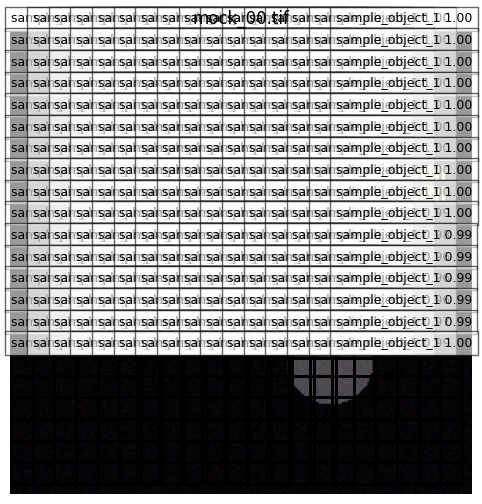

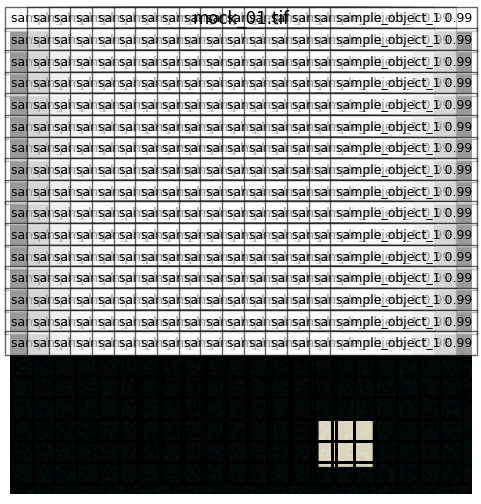

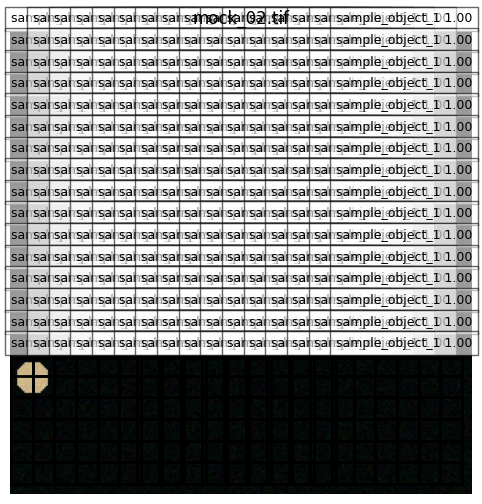

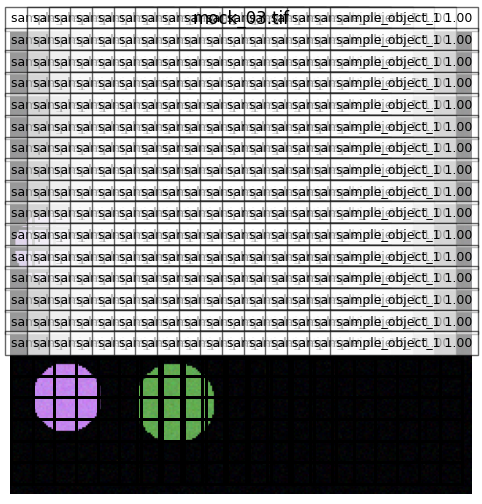

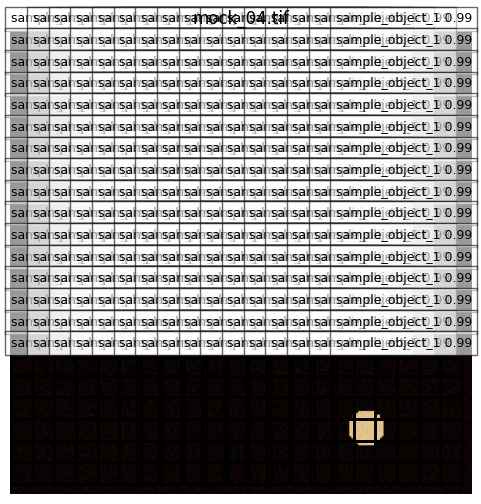

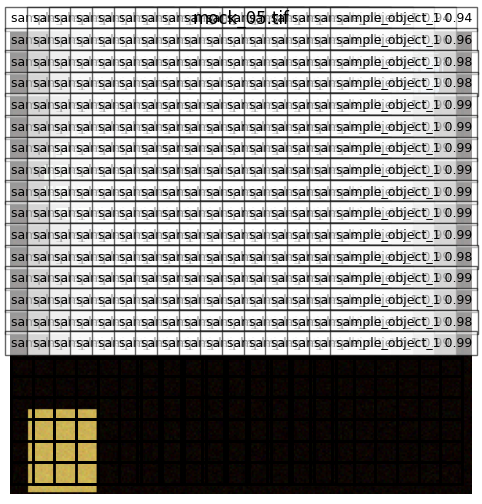

In [37]:
from collections import defaultdict
det_by_file = defaultdict(list)
for (xmin,ymin,xmax,ymax,obj,fn,sim) in detections:
    det_by_file[fn].append((xmin,ymin,xmax,ymax,obj,sim))

for fn in sorted(det_by_file.keys()):
    arr = load_multiband(os.path.join(MOCK_DIR, fn))
    plt.figure(figsize=(6,6))
    plt.imshow(rgb_preview(arr)); ax = plt.gca()
    for (xmin,ymin,xmax,ymax,obj,sim) in det_by_file[fn]:
        ax.add_patch(Rectangle((xmin,ymin), xmax-xmin, ymax-ymin, fill=False, linewidth=2))
        ax.text(xmin, ymin-6, f"{obj} {sim:.2f}", fontsize=9, bbox=dict(facecolor='white', alpha=0.6))
    plt.title(fn)
    plt.axis('off')
    plt.show()
